<a href="https://colab.research.google.com/github/amrish1222/DL_pytorch_classification/blob/master/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install torch torchvision

In [0]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [0]:
transforms_train = transforms.Compose([transforms.Resize((32,32)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.RandomAffine(0, shear = 10, scale = (0.8,1.2)),
                                       transforms.ColorJitter(brightness = 0.2, contrast= 0.2, saturation = 0.2),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,),(0.5,))
                               ])

transforms = transforms.Compose([transforms.Resize((32,32)),
                                 transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))
                               ])

training_dataset = datasets.CIFAR10(root = './data', train = True, download = True, transform = transforms_train)
validation_dataset = datasets.CIFAR10(root = './data', train = False, download = True, transform = transforms)

training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 100, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle = False)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
def im_convert(tensor):
  image = tensor.clone().cpu().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

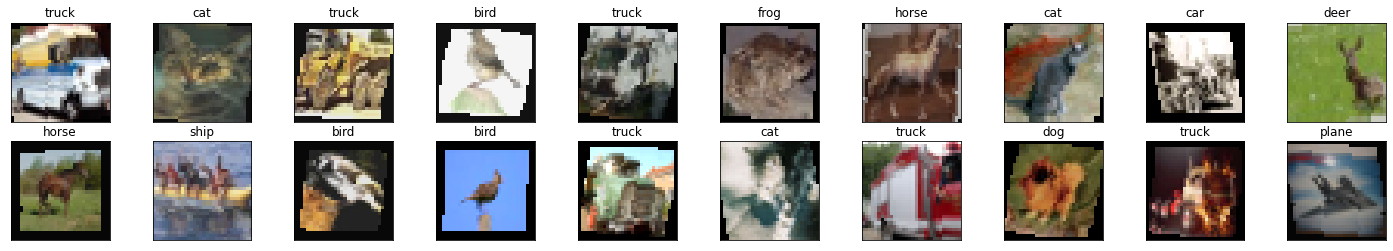

In [0]:
data_iter = iter(training_loader)
images, labels = data_iter.next()
fig = plt.figure(figsize = (25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10,idx+1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])
  

In [0]:
class LeNet(nn.Module):

  def __init__(self, ):
    super().__init__()
    self.conv1 = nn.Conv2d( 3, 32, 3, 1, padding = 1)
    self.conv2 = nn.Conv2d( 32, 64, 3, 1, padding = 1)
    self.conv3 = nn.Conv2d( 64, 128, 3, 1, padding = 1)
    self.fc1 = nn.Linear(4*4*128, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, X):
    x = F.relu(self.conv1(X))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*128)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [0]:
torch.manual_seed(10)
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.005)

In [0]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
 
for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
 
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.7114, acc 36.7000 
validation loss: 1.4292, validation acc 47.5200 
epoch : 2
training loss: 1.4743, acc 46.5980 
validation loss: 1.3395, validation acc 50.8100 
epoch : 3
training loss: 1.4180, acc 48.8040 
validation loss: 1.3231, validation acc 52.4100 
epoch : 4
training loss: 1.3819, acc 50.3900 
validation loss: 1.2941, validation acc 54.0700 
epoch : 5
training loss: 1.3533, acc 51.8900 
validation loss: 1.2737, validation acc 55.7800 
epoch : 6
training loss: 1.3275, acc 52.9180 
validation loss: 1.2485, validation acc 56.5000 
epoch : 7
training loss: 1.3304, acc 52.6120 
validation loss: 1.2017, validation acc 57.5100 
epoch : 8
training loss: 1.3217, acc 53.0380 
validation loss: 1.2267, validation acc 57.5600 
epoch : 9
training loss: 1.3129, acc 53.2880 
validation loss: 1.1932, validation acc 58.5000 
epoch : 10
training loss: 1.2807, acc 54.5700 
validation loss: 1.1961, validation acc 58.0300 
epoch : 11
training loss: 1.2941, acc 54.2100 
va

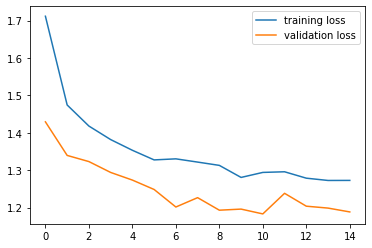

In [0]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

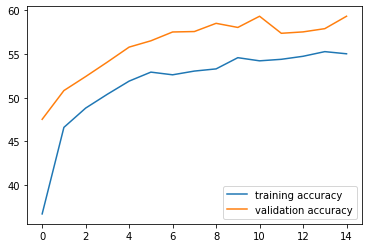

In [0]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'validation accuracy')
plt.legend()

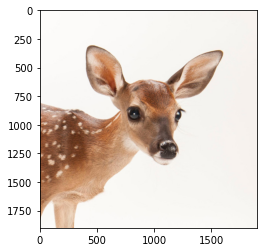

In [0]:
import requests
from PIL import Image
import PIL
url = 'https://www.nationalgeographic.com/content/dam/animals/thumbs/rights-exempt/mammals/w/white-tailed-deer_thumb.ngsversion.1481754616484.adapt.1900.1.JPG'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)


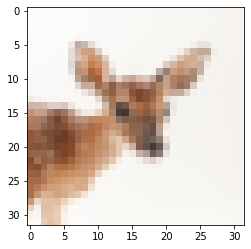

In [0]:
img = transforms(img)
plt.imshow(im_convert(img))

In [0]:
img = img.to(device)
output = model.forward(img.unsqueeze(0))
_,pred = torch.max(output,1)
print(classes[pred.item()])

cat


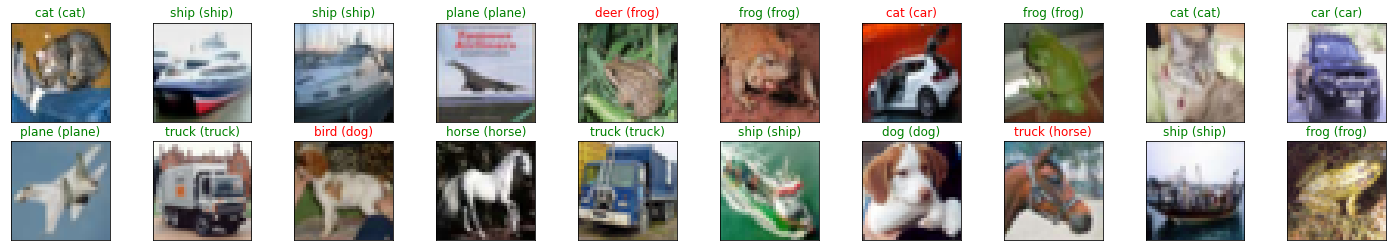

In [0]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))
